In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch import Tensor
from typing import Optional, Tuple

In [2]:
class Swish(nn.Module):
    """
    Swish is a smooth, non-monotonic function that consistently matches or outperforms ReLU on deep networks applied
    to a variety of challenging domains such as Image classification and Machine translation.
    """
    def __init__(self):
        super(Swish, self).__init__()
    
    def forward(self, inputs: Tensor) -> Tensor:
        return inputs * inputs.sigmoid()


class GLU(nn.Module):
    """
    The gating mechanism is called Gated Linear Units (GLU), which was first introduced for natural language processing
    in the paper “Language Modeling with Gated Convolutional Networks”
    """
    def __init__(self, dim: int) -> None:
        super(GLU, self).__init__()
        self.dim = dim

    def forward(self, inputs: Tensor) -> Tensor:
        outputs, gate = inputs.chunk(2, dim=self.dim)
        return outputs * gate.sigmoid()

In [3]:
class ResidualConnectionModule(nn.Module):
    """
    Residual Connection Module.
    outputs = (module(inputs) x module_factor + inputs x input_factor)
    """
    def __init__(self, module: nn.Module, module_factor: float = 1.0, input_factor: float = 1.0):
        super(ResidualConnectionModule, self).__init__()
        self.module = module
        self.module_factor = module_factor
        self.input_factor = input_factor

    def forward(self, inputs: Tensor) -> Tensor:
        return (self.module(inputs) * self.module_factor) + (inputs * self.input_factor)

In [4]:
class Linear(nn.Module):
    """
    Wrapper class of torch.nn.Linear
    Weight initialize by xavier initialization and bias initialize to zeros.
    """
    def __init__(self, in_features: int, out_features: int, bias: bool = True) -> None:
        super(Linear, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        init.xavier_uniform_(self.linear.weight)
        if bias:
            init.zeros_(self.linear.bias)

    def forward(self, x: Tensor) -> Tensor:
        return self.linear(x)

In [5]:
class View(nn.Module):
    """ Wrapper class of torch.view() for Sequential module. """
    def __init__(self, shape: tuple, contiguous: bool = False):
        super(View, self).__init__()
        self.shape = shape
        self.contiguous = contiguous

    def forward(self, x: Tensor) -> Tensor:
        if self.contiguous:
            x = x.contiguous()

        return x.view(*self.shape)

In [6]:
class Transpose(nn.Module):
    """ Wrapper class of torch.transpose() for Sequential module. """
    def __init__(self, shape: tuple):
        super(Transpose, self).__init__()
        self.shape = shape

    def forward(self, x: Tensor) -> Tensor:
        return x.transpose(*self.shape)

In [7]:
class PositionalEncoding(nn.Module):
    """
    Positional Encoding proposed in "Attention Is All You Need".
    Since transformer contains no recurrence and no convolution, in order for the model to make
    use of the order of the sequence, we must add some positional information.
    "Attention Is All You Need" use sine and cosine functions of different frequencies:
        PE_(pos, 2i)    =  sin(pos / power(10000, 2i / d_model))
        PE_(pos, 2i+1)  =  cos(pos / power(10000, 2i / d_model))
    """
    def __init__(self, d_model: int = 512, max_len: int = 10000) -> None:
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model, requires_grad=False)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, length: int) -> Tensor:
        return self.pe[:, :length]

In [8]:
class RelativeMultiHeadAttention(nn.Module):
    """
    Multi-head attention with relative positional encoding.
    This concept was proposed in the "Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context"
    Args:
        d_model (int): The dimension of model
        num_heads (int): The number of attention heads.
        dropout_p (float): probability of dropout
    Inputs: query, key, value, pos_embedding, mask
        - **query** (batch, time, dim): Tensor containing query vector
        - **key** (batch, time, dim): Tensor containing key vector
        - **value** (batch, time, dim): Tensor containing value vector
        - **pos_embedding** (batch, time, dim): Positional embedding tensor
        - **mask** (batch, 1, time2) or (batch, time1, time2): Tensor containing indices to be masked
    Returns:
        - **outputs**: Tensor produces by relative multi head attention module.
    """
    def __init__(
            self,
            d_model: int = 512,
            num_heads: int = 16,
            dropout_p: float = 0.1,
    ):
        super(RelativeMultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model % num_heads should be zero."
        self.d_model = d_model
        self.d_head = int(d_model / num_heads)
        self.num_heads = num_heads
        self.sqrt_dim = math.sqrt(d_model)

        self.query_proj = Linear(d_model, d_model)
        self.key_proj = Linear(d_model, d_model)
        self.value_proj = Linear(d_model, d_model)
        self.pos_proj = Linear(d_model, d_model, bias=False)

        self.dropout = nn.Dropout(p=dropout_p)
        self.u_bias = nn.Parameter(torch.Tensor(self.num_heads, self.d_head))
        self.v_bias = nn.Parameter(torch.Tensor(self.num_heads, self.d_head))
        torch.nn.init.xavier_uniform_(self.u_bias)
        torch.nn.init.xavier_uniform_(self.v_bias)

        self.out_proj = Linear(d_model, d_model)

    def forward(
            self,
            query: Tensor,
            key: Tensor,
            value: Tensor,
            pos_embedding: Tensor,
            mask: Optional[Tensor] = None,
    ) -> Tensor:
        batch_size = value.size(0)

        query = self.query_proj(query).view(batch_size, -1, self.num_heads, self.d_head)
        key = self.key_proj(key).view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        value = self.value_proj(value).view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        pos_embedding = self.pos_proj(pos_embedding).view(batch_size, -1, self.num_heads, self.d_head)

        content_score = torch.matmul((query + self.u_bias).transpose(1, 2), key.transpose(2, 3))
        pos_score = torch.matmul((query + self.v_bias).transpose(1, 2), pos_embedding.permute(0, 2, 3, 1))
        pos_score = self._relative_shift(pos_score)
        
        score = (content_score + pos_score) / self.sqrt_dim

        if mask is not None:
            mask = mask.unsqueeze(1)
            score.masked_fill_(mask, -1e9)

        attn = F.softmax(score, -1)
        attn = self.dropout(attn)

        context = torch.matmul(attn, value).transpose(1, 2)
        context = context.contiguous().view(batch_size, -1, self.d_model)

        return self.out_proj(context)

    def _relative_shift(self, pos_score: Tensor) -> Tensor:
        batch_size, num_heads, seq_length1, seq_length2 = pos_score.size()
        zeros = pos_score.new_zeros(batch_size, num_heads, seq_length1, 1)
        padded_pos_score = torch.cat([zeros, pos_score], dim=-1)

        padded_pos_score = padded_pos_score.view(batch_size, num_heads, seq_length2 + 1, seq_length1)
        pos_score = padded_pos_score[:, :, 1:].view_as(pos_score)

        return pos_score

In [9]:
class CrossRelativeMultiHeadAttention(nn.Module):
    """
    Multi-head attention with relative positional encoding.
    This concept was proposed in the "Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context"
    Args:
        d_model (int): The dimension of model
        num_heads (int): The number of attention heads.
        dropout_p (float): probability of dropout
    Inputs: query, key, value, pos_embedding, mask
        - **query** (batch, time, dim): Tensor containing query vector
        - **key** (batch, time, dim): Tensor containing key vector
        - **value** (batch, time, dim): Tensor containing value vector
        - **pos_embedding** (batch, time, dim): Positional embedding tensor
        - **mask** (batch, 1, time2) or (batch, time1, time2): Tensor containing indices to be masked
    Returns:
        - **outputs**: Tensor produces by relative multi head attention module.
    """
    def __init__(
            self,
            d_model: int = 512,
            num_heads: int = 16,
            dropout_p: float = 0.1,
    ):
        super(CrossRelativeMultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model % num_heads should be zero."
        self.d_model = d_model
        self.d_head = int(d_model / num_heads)
        self.num_heads = num_heads
        self.sqrt_dim = math.sqrt(d_model)

        self.query_proj = Linear(d_model, d_model)
        self.key_proj = Linear(d_model, d_model)
        self.value_proj = Linear(d_model, d_model)
        self.pos_proj = Linear(d_model, d_model, bias=False)

        self.dropout = nn.Dropout(p=dropout_p)
        self.u_bias = nn.Parameter(torch.Tensor(self.num_heads, self.d_head))
        self.v_bias = nn.Parameter(torch.Tensor(self.num_heads, self.d_head))
        torch.nn.init.xavier_uniform_(self.u_bias)
        torch.nn.init.xavier_uniform_(self.v_bias)

        self.out_proj = Linear(d_model, d_model)

    def forward(
            self,
            query: Tensor,
            key: Tensor,
            value: Tensor,
            pos_embedding: Tensor,
            mask: Optional[Tensor] = None,
    ) -> Tensor:
        batch_size = value.size(0)

        query = self.query_proj(query).view(batch_size, -1, self.num_heads, self.d_head)
        key = self.key_proj(key).view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        value = self.value_proj(value).view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        pos_embedding = self.pos_proj(pos_embedding).view(batch_size, -1, self.num_heads, self.d_head)

        content_score = torch.matmul((query + self.u_bias).transpose(1, 2), key.transpose(2, 3))
        pos_score = torch.matmul((query + self.v_bias).transpose(1, 2), pos_embedding.permute(0, 2, 3, 1))
        pos_score = self._relative_shift(pos_score)
        
        score = (content_score + pos_score) / self.sqrt_dim

        if mask is not None:
            mask = mask.unsqueeze(1)
            score.masked_fill_(mask, -1e9)

        attn = F.softmax(score, -1)
        attn = self.dropout(attn)

        context = torch.matmul(attn, value).transpose(1, 2)
        context = context.contiguous().view(batch_size, -1, self.d_model)

        return self.out_proj(context)

    def _relative_shift(self, pos_score: Tensor) -> Tensor:
        batch_size, num_heads, seq_length1, seq_length2 = pos_score.size()
        zeros = pos_score.new_zeros(batch_size, num_heads, seq_length1, 1)
        padded_pos_score = torch.cat([zeros, pos_score], dim=-1)

        padded_pos_score = padded_pos_score.view(batch_size, num_heads, seq_length2 + 1, seq_length1)
        pos_score = padded_pos_score[:, :, 1:].view_as(pos_score)

        return pos_score

In [10]:
class MultiHeadedSelfAttentionModule(nn.Module):
    """
    Conformer employ multi-headed self-attention (MHSA) while integrating an important technique from Transformer-XL,
    the relative sinusoidal positional encoding scheme. The relative positional encoding allows the self-attention
    module to generalize better on different input length and the resulting encoder is more robust to the variance of
    the utterance length. Conformer use prenorm residual units with dropout which helps training
    and regularizing deeper models.
    Args:
        d_model (int): The dimension of model
        num_heads (int): The number of attention heads.
        dropout_p (float): probability of dropout
    Inputs: inputs, mask
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **mask** (batch, 1, time2) or (batch, time1, time2): Tensor containing indices to be masked
    Returns:
        - **outputs** (batch, time, dim): Tensor produces by relative multi headed self attention module.
    """
    def __init__(self, d_model: int, num_heads: int, dropout_p: float = 0.1):
        super(MultiHeadedSelfAttentionModule, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        self.attention = RelativeMultiHeadAttention(d_model, num_heads, dropout_p)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, inputs: Tensor, mask: Optional[Tensor] = None):
        batch_size, seq_length, _ = inputs.size()
        pos_embedding = self.positional_encoding(seq_length)
        pos_embedding = pos_embedding.repeat(batch_size, 1, 1)

        inputs = self.layer_norm(inputs)
        outputs = self.attention(inputs, inputs, inputs, pos_embedding=pos_embedding, mask=mask)

        return self.dropout(outputs)

In [11]:
class CrossMultiHeadedSelfAttentionModule(nn.Module):
    """
    Conformer employ multi-headed self-attention (MHSA) while integrating an important technique from Transformer-XL,
    the relative sinusoidal positional encoding scheme. The relative positional encoding allows the self-attention
    module to generalize better on different input length and the resulting encoder is more robust to the variance of
    the utterance length. Conformer use prenorm residual units with dropout which helps training
    and regularizing deeper models.
    Args:
        d_model (int): The dimension of model
        num_heads (int): The number of attention heads.
        dropout_p (float): probability of dropout
    Inputs: inputs, mask
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **mask** (batch, 1, time2) or (batch, time1, time2): Tensor containing indices to be masked
    Returns:
        - **outputs** (batch, time, dim): Tensor produces by relative multi headed self attention module.
    """
    def __init__(self, d_model: int, num_heads: int, dropout_p: float = 0.1):
        super(CrossMultiHeadedSelfAttentionModule, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        self.attention = CrossRelativeMultiHeadAttention(d_model, num_heads, dropout_p)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, inputs: Tensor, encoder_output: Tensor, mask: Optional[Tensor] = None):
        batch_size, seq_length, _ = inputs.size()
        seq_length = encoder_output.size(1)
        pos_embedding = self.positional_encoding(seq_length)
        pos_embedding = pos_embedding.repeat(batch_size, 1, 1)

        inputs = self.layer_norm(inputs)   
        outputs = self.attention(inputs, encoder_output, encoder_output, pos_embedding=pos_embedding, mask=mask)

        return self.dropout(outputs)

In [12]:
class DepthwiseConv1d(nn.Module):
    """
    When groups == in_channels and out_channels == K * in_channels, where K is a positive integer,
    this operation is termed in literature as depthwise convolution.
    Args:
        in_channels (int): Number of channels in the input
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int or tuple): Size of the convolving kernel
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        bias (bool, optional): If True, adds a learnable bias to the output. Default: True
    Inputs: inputs
        - **inputs** (batch, in_channels, time): Tensor containing input vector
    Returns: outputs
        - **outputs** (batch, out_channels, time): Tensor produces by depthwise 1-D convolution.
    """
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            stride: int = 1,
            padding: int = 0,
            bias: bool = False,
    ) -> None:
        super(DepthwiseConv1d, self).__init__()
        assert out_channels % in_channels == 0, "out_channels should be constant multiple of in_channels"
        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            groups=in_channels,
            stride=stride,
            padding=padding,
            bias=bias,
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.conv(inputs)

In [13]:
class PointwiseConv1d(nn.Module):
    """
    When kernel size == 1 conv1d, this operation is termed in literature as pointwise convolution.
    This operation often used to match dimensions.
    Args:
        in_channels (int): Number of channels in the input
        out_channels (int): Number of channels produced by the convolution
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        bias (bool, optional): If True, adds a learnable bias to the output. Default: True
    Inputs: inputs
        - **inputs** (batch, in_channels, time): Tensor containing input vector
    Returns: outputs
        - **outputs** (batch, out_channels, time): Tensor produces by pointwise 1-D convolution.
    """
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            stride: int = 1,
            padding: int = 0,
            bias: bool = True,
    ) -> None:
        super(PointwiseConv1d, self).__init__()
        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=stride,
            padding=padding,
            bias=bias,
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.conv(inputs)


In [14]:
class ConformerConvModule(nn.Module):
    """
    Conformer convolution module starts with a pointwise convolution and a gated linear unit (GLU).
    This is followed by a single 1-D depthwise convolution layer. Batchnorm is  deployed just after the convolution
    to aid training deep models.
    Args:
        in_channels (int): Number of channels in the input
        kernel_size (int or tuple, optional): Size of the convolving kernel Default: 31
        dropout_p (float, optional): probability of dropout
    Inputs: inputs
        inputs (batch, time, dim): Tensor contains input sequences
    Outputs: outputs
        outputs (batch, time, dim): Tensor produces by conformer convolution module.
    """
    def __init__(
            self,
            in_channels: int,
            kernel_size: int = 31,
            expansion_factor: int = 2,
            dropout_p: float = 0.1,
    ) -> None:
        super(ConformerConvModule, self).__init__()
        assert (kernel_size - 1) % 2 == 0, "kernel_size should be a odd number for 'SAME' padding"
        assert expansion_factor == 2, "Currently, Only Supports expansion_factor 2"

        self.sequential = nn.Sequential(
            nn.LayerNorm(in_channels),
            Transpose(shape=(1, 2)),
            PointwiseConv1d(in_channels, in_channels * expansion_factor, stride=1, padding=0, bias=True),
            GLU(dim=1),
            DepthwiseConv1d(in_channels, in_channels, kernel_size, stride=1, padding=(kernel_size - 1) // 2),
            nn.BatchNorm1d(in_channels),
            Swish(),
            PointwiseConv1d(in_channels, in_channels, stride=1, padding=0, bias=True),
            nn.Dropout(p=dropout_p),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.sequential(inputs).transpose(1, 2)

In [15]:
class EncoderConv2dSubampling(nn.Module):
    """
    Convolutional 2D subsampling (to 1/4 length)
    Args:
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the convolution
    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing sequence of inputs
    Returns: outputs, output_lengths
        - **outputs** (batch, time, dim): Tensor produced by the convolution
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(EncoderConv2dSubampling, self).__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1),
            nn.ReLU(),
        )

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        outputs = self.sequential(inputs.unsqueeze(1))
        batch_size, channels, subsampled_lengths, sumsampled_dim = outputs.size()

        outputs = outputs.permute(0, 2, 1, 3)
        outputs = outputs.contiguous().view(batch_size, subsampled_lengths, channels * sumsampled_dim)

        output_lengths = input_lengths >> 2
        output_lengths -= 1

        return outputs, output_lengths

In [16]:
class DecoderConv2dSubampling(nn.Module):
    """
    Convolutional 2D subsampling (to 1/4 length)
    Args:
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the convolution
    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing sequence of inputs
    Returns: outputs, output_lengths
        - **outputs** (batch, time, dim): Tensor produced by the convolution
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(DecoderConv2dSubampling, self).__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1),
            nn.ReLU(),
        )

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        outputs = self.sequential(inputs.unsqueeze(1))
        batch_size, channels, subsampled_lengths, sumsampled_dim = outputs.size()

        outputs = outputs.permute(0, 2, 1, 3)
        outputs = outputs.contiguous().view(batch_size, subsampled_lengths, channels * sumsampled_dim)

        output_lengths = input_lengths >> 2
        output_lengths -= 1

        return outputs, output_lengths

In [17]:
class FeedForwardModule(nn.Module):
    """
    Conformer Feed Forward Module follow pre-norm residual units and apply layer normalization within the residual unit
    and on the input before the first linear layer. This module also apply Swish activation and dropout, which helps
    regularizing the network.
    Args:
        encoder_dim (int): Dimension of conformer encoder
        expansion_factor (int): Expansion factor of feed forward module.
        dropout_p (float): Ratio of dropout
    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor contains input sequences
    Outputs: outputs
        - **outputs** (batch, time, dim): Tensor produces by feed forward module.
    """
    def __init__(
            self,
            encoder_dim: int = 512,
            expansion_factor: int = 4,
            dropout_p: float = 0.1,
    ) -> None:
        super(FeedForwardModule, self).__init__()
        self.sequential = nn.Sequential(
            nn.LayerNorm(encoder_dim),
            Linear(encoder_dim, encoder_dim * expansion_factor, bias=True),
            Swish(),
            nn.Dropout(p=dropout_p),
            Linear(encoder_dim * expansion_factor, encoder_dim, bias=True),
            nn.Dropout(p=dropout_p),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.sequential(inputs)

In [18]:
class EncoderConformerBlock(nn.Module):
    """
    Conformer block contains two Feed Forward modules sandwiching the Multi-Headed Self-Attention module
    and the Convolution module. This sandwich structure is inspired by Macaron-Net, which proposes replacing
    the original feed-forward layer in the Transformer block into two half-step feed-forward layers,
    one before the attention layer and one after.
    Args:
        encoder_dim (int, optional): Dimension of conformer encoder
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not
    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing input vector
    Returns: outputs
        - **outputs** (batch, time, dim): Tensor produces by conformer block.
    """
    def __init__(
            self,
            encoder_dim: int = 512,
            num_attention_heads: int = 8,
            feed_forward_expansion_factor: int = 4,
            conv_expansion_factor: int = 2,
            feed_forward_dropout_p: float = 0.1,
            attention_dropout_p: float = 0.1,
            conv_dropout_p: float = 0.1,
            conv_kernel_size: int = 31,
            half_step_residual: bool = True,
    ):
        super(EncoderConformerBlock, self).__init__()
        if half_step_residual:
            self.feed_forward_residual_factor = 0.5
        else:
            self.feed_forward_residual_factor = 1

        self.sequential = nn.Sequential(
            ResidualConnectionModule(
                module=FeedForwardModule(
                    encoder_dim=encoder_dim,
                    expansion_factor=feed_forward_expansion_factor,
                    dropout_p=feed_forward_dropout_p,
                ),
                module_factor=self.feed_forward_residual_factor,
            ),
            ResidualConnectionModule(
                module=MultiHeadedSelfAttentionModule(
                    d_model=encoder_dim,
                    num_heads=num_attention_heads,
                    dropout_p=attention_dropout_p,
                ),
            ),
            ResidualConnectionModule(
                module=ConformerConvModule(
                    in_channels=encoder_dim,
                    kernel_size=conv_kernel_size,
                    expansion_factor=conv_expansion_factor,
                    dropout_p=conv_dropout_p,
                ),
            ),
            ResidualConnectionModule(
                module=FeedForwardModule(
                    encoder_dim=encoder_dim,
                    expansion_factor=feed_forward_expansion_factor,
                    dropout_p=feed_forward_dropout_p,
                ),
                module_factor=self.feed_forward_residual_factor,
            ),
            nn.LayerNorm(encoder_dim),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.sequential(inputs)

In [19]:
class DecoderConformerBlock(nn.Module):
    """
    Conformer block contains two Feed Forward modules sandwiching the Multi-Headed Self-Attention module
    and the Convolution module. This sandwich structure is inspired by Macaron-Net, which proposes replacing
    the original feed-forward layer in the Transformer block into two half-step feed-forward layers,
    one before the attention layer and one after.
    Args:
        encoder_dim (int, optional): Dimension of conformer encoder
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not
    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing input vector
    Returns: outputs
        - **outputs** (batch, time, dim): Tensor produces by conformer block.
    """
    def __init__(
            self,
            encoder_dim: int = 512,
            num_attention_heads: int = 8,
            feed_forward_expansion_factor: int = 4,
            conv_expansion_factor: int = 2,
            feed_forward_dropout_p: float = 0.1,
            attention_dropout_p: float = 0.1,
            conv_dropout_p: float = 0.1,
            conv_kernel_size: int = 31,
            half_step_residual: bool = True,
    ):
        super(DecoderConformerBlock, self).__init__()
        if half_step_residual:
            self.feed_forward_residual_factor = 0.5
        else:
            self.feed_forward_residual_factor = 1

        self.feedforward1=FeedForwardModule(
            encoder_dim=encoder_dim,
            expansion_factor=feed_forward_expansion_factor,
            dropout_p=feed_forward_dropout_p,
        )
        
        self.multiheadedselfattention1=MultiHeadedSelfAttentionModule(
            d_model=encoder_dim,
            num_heads=num_attention_heads,
            dropout_p=attention_dropout_p,
        )
        
        self.feedforward2=FeedForwardModule(
            encoder_dim=encoder_dim,
            expansion_factor=feed_forward_expansion_factor,
            dropout_p=feed_forward_dropout_p,
        )
        
        self.multiheadedselfattention2=CrossMultiHeadedSelfAttentionModule(
            d_model=encoder_dim,
            num_heads=num_attention_heads,
            dropout_p=attention_dropout_p,
        )
        
        self.conformerconv=ConformerConvModule(
            in_channels=encoder_dim,
            kernel_size=conv_kernel_size,
            expansion_factor=conv_expansion_factor,
            dropout_p=conv_dropout_p,
        )
        
        self.feedforward3=FeedForwardModule(
            encoder_dim=encoder_dim,
            expansion_factor=feed_forward_expansion_factor,
            dropout_p=feed_forward_dropout_p,
        )
        
        self.layernorm=nn.LayerNorm(encoder_dim)

    def forward(self, inputs: Tensor, encoder_output: Tensor) -> Tensor:
        
        x = self.feedforward1(inputs)
        y = 1/2*x + inputs
        x = self.multiheadedselfattention1(y)
        y = x + y
        x = self.feedforward2(y)
        y = x + y
        x = self.multiheadedselfattention2(y, encoder_output)
        y = x + y
        x = self.conformerconv(y)
        y = x + y
        x = self.feedforward3(y)
        y = 1/2*x + y
        x = self.layernorm(y)
        
        return x

In [20]:
class ConformerEncoder(nn.Module):
    """
    Conformer encoder first processes the input with a convolution subsampling layer and then
    with a number of conformer blocks.
    Args:
        input_dim (int, optional): Dimension of input vector
        encoder_dim (int, optional): Dimension of conformer encoder
        num_layers (int, optional): Number of conformer blocks
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not
    Inputs: inputs, input_lengths
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **input_lengths** (batch): list of sequence input lengths
    Returns: outputs, output_lengths
        - **outputs** (batch, out_channels, time): Tensor produces by conformer encoder.
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(
            self,
            input_dim: int = 80,
            encoder_dim: int = 512,
            num_layers: int = 17,
            num_attention_heads: int = 8,
            feed_forward_expansion_factor: int = 4,
            conv_expansion_factor: int = 2,
            input_dropout_p: float = 0.1,
            feed_forward_dropout_p: float = 0.1,
            attention_dropout_p: float = 0.1,
            conv_dropout_p: float = 0.1,
            conv_kernel_size: int = 31,
            half_step_residual: bool = True,
    ):
        super(ConformerEncoder, self).__init__()
        self.conv_subsample = EncoderConv2dSubampling(in_channels=1, out_channels=encoder_dim)
        self.input_projection = nn.Sequential(
            Linear(encoder_dim * (((input_dim - 3) // 1 + 1 - 3) // 1 + 1), encoder_dim),
            nn.Dropout(p=input_dropout_p),
        )
        self.layers = nn.ModuleList([EncoderConformerBlock(
            encoder_dim=encoder_dim,
            num_attention_heads=num_attention_heads,
            feed_forward_expansion_factor=feed_forward_expansion_factor,
            conv_expansion_factor=conv_expansion_factor,
            feed_forward_dropout_p=feed_forward_dropout_p,
            attention_dropout_p=attention_dropout_p,
            conv_dropout_p=conv_dropout_p,
            conv_kernel_size=conv_kernel_size,
            half_step_residual=half_step_residual,
        ) for _ in range(num_layers)])

    def count_parameters(self) -> int:
        """ Count parameters of encoder """
        return sum([p.numel() for p in self.parameters()])

    def update_dropout(self, dropout_p: float) -> None:
        """ Update dropout probability of encoder """
        for name, child in self.named_children():
            if isinstance(child, nn.Dropout):
                child.p = dropout_p

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Forward propagate a `inputs` for  encoder training.
        Args:
            inputs (torch.FloatTensor): A input sequence passed to encoder. Typically for inputs this will be a padded
                `FloatTensor` of size ``(batch, seq_length, dimension)``.
            input_lengths (torch.LongTensor): The length of input tensor. ``(batch)``
        Returns:
            (Tensor, Tensor)
            * outputs (torch.FloatTensor): A output sequence of encoder. `FloatTensor` of size
                ``(batch, seq_length, dimension)``
            * output_lengths (torch.LongTensor): The length of output tensor. ``(batch)``
        """
        outputs, output_lengths = self.conv_subsample(inputs, input_lengths)
        outputs = self.input_projection(outputs)

        for layer in self.layers:
            outputs = layer(outputs)

        return outputs, output_lengths

In [21]:
class ConformerDecoder(nn.Module):
    """
    Conformer encoder first processes the input with a convolution subsampling layer and then
    with a number of conformer blocks.
    Args:
        input_dim (int, optional): Dimension of input vector
        encoder_dim (int, optional): Dimension of conformer encoder
        num_layers (int, optional): Number of conformer blocks
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not
    Inputs: inputs, input_lengths
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **input_lengths** (batch): list of sequence input lengths
    Returns: outputs, output_lengths
        - **outputs** (batch, out_channels, time): Tensor produces by conformer encoder.
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(
            self,
            input_dim: int = 80,
            encoder_dim: int = 512,
            num_layers: int = 17,
            num_attention_heads: int = 8,
            feed_forward_expansion_factor: int = 4,
            conv_expansion_factor: int = 2,
            input_dropout_p: float = 0.1,
            feed_forward_dropout_p: float = 0.1,
            attention_dropout_p: float = 0.1,
            conv_dropout_p: float = 0.1,
            conv_kernel_size: int = 31,
            half_step_residual: bool = True,
    ):
        super(ConformerDecoder, self).__init__()
        self.conv_subsample = DecoderConv2dSubampling(in_channels=1, out_channels=encoder_dim)
        self.input_projection = nn.Sequential(
            Linear(encoder_dim * input_dim, encoder_dim),
            nn.Dropout(p=input_dropout_p),
        )
        self.layers = nn.ModuleList([DecoderConformerBlock(
            encoder_dim=encoder_dim,
            num_attention_heads=num_attention_heads,
            feed_forward_expansion_factor=feed_forward_expansion_factor,
            conv_expansion_factor=conv_expansion_factor,
            feed_forward_dropout_p=feed_forward_dropout_p,
            attention_dropout_p=attention_dropout_p,
            conv_dropout_p=conv_dropout_p,
            conv_kernel_size=conv_kernel_size,
            half_step_residual=half_step_residual,
        ) for _ in range(num_layers)])

    def count_parameters(self) -> int:
        """ Count parameters of encoder """
        return sum([p.numel() for p in self.parameters()])

    def update_dropout(self, dropout_p: float) -> None:
        """ Update dropout probability of encoder """
        for name, child in self.named_children():
            if isinstance(child, nn.Dropout):
                child.p = dropout_p

    def forward(self, inputs: Tensor, encoder_output: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Forward propagate a `inputs` for  encoder training.
        Args:
            inputs (torch.FloatTensor): A input sequence passed to encoder. Typically for inputs this will be a padded
                `FloatTensor` of size ``(batch, seq_length, dimension)``.
            input_lengths (torch.LongTensor): The length of input tensor. ``(batch)``
        Returns:
            (Tensor, Tensor)
            * outputs (torch.FloatTensor): A output sequence of encoder. `FloatTensor` of size
                ``(batch, seq_length, dimension)``
            * output_lengths (torch.LongTensor): The length of output tensor. ``(batch)``
        """
        outputs, output_lengths = self.conv_subsample(inputs, input_lengths)
        outputs = self.input_projection(outputs)

        for layer in self.layers:
            outputs = layer(outputs, encoder_output)

        return outputs, output_lengths

In [22]:
class Conformer(nn.Module):
    """
    Conformer: Convolution-augmented Transformer for Speech Recognition
    The paper used a one-lstm Transducer decoder, currently still only implemented
    the conformer encoder shown in the paper.
    Args:
        num_classes (int): Number of classification classes
        input_dim (int, optional): Dimension of input vector
        encoder_dim (int, optional): Dimension of conformer encoder
        num_encoder_layers (int, optional): Number of conformer blocks
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not
    Inputs: inputs, input_lengths
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **input_lengths** (batch): list of sequence input lengths
    Returns: outputs, output_lengths
        - **outputs** (batch, out_channels, time): Tensor produces by conformer.
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(
            self,
            num_classes: int,
            input_dim: int = 80,
            encoder_dim: int = 512,
            num_encoder_layers: int = 17,
            num_decoder_layers: int = 17,
            num_attention_heads: int = 8,
            feed_forward_expansion_factor: int = 4,
            conv_expansion_factor: int = 2,
            input_dropout_p: float = 0.1,
            feed_forward_dropout_p: float = 0.1,
            attention_dropout_p: float = 0.1,
            conv_dropout_p: float = 0.1,
            conv_kernel_size: int = 31,
            half_step_residual: bool = True,
    ) -> None:
        super(Conformer, self).__init__()
        self.encoder = ConformerEncoder(
            input_dim=input_dim,
            encoder_dim=encoder_dim,
            num_layers=num_encoder_layers,
            num_attention_heads=num_attention_heads,
            feed_forward_expansion_factor=feed_forward_expansion_factor,
            conv_expansion_factor=conv_expansion_factor,
            input_dropout_p=input_dropout_p,
            feed_forward_dropout_p=feed_forward_dropout_p,
            attention_dropout_p=attention_dropout_p,
            conv_dropout_p=conv_dropout_p,
            conv_kernel_size=conv_kernel_size,
            half_step_residual=half_step_residual,
        )
        
        self.decoder = ConformerDecoder(
            input_dim=input_dim,
            encoder_dim=encoder_dim,
            num_layers=num_decoder_layers,
            num_attention_heads=num_attention_heads,
            feed_forward_expansion_factor=feed_forward_expansion_factor,
            conv_expansion_factor=conv_expansion_factor,
            input_dropout_p=input_dropout_p,
            feed_forward_dropout_p=feed_forward_dropout_p,
            attention_dropout_p=attention_dropout_p,
            conv_dropout_p=conv_dropout_p,
            conv_kernel_size=conv_kernel_size,
            half_step_residual=half_step_residual,
        )
        self.fc = Linear(encoder_dim, num_classes, bias=False)
        self.W = nn.Linear(num_classes, 1)

    def count_parameters(self) -> int:
        """ Count parameters of encoder """
        return self.encoder.count_parameters()

    def update_dropout(self, dropout_p) -> None:
        """ Update dropout probability of model """
        self.encoder.update_dropout(dropout_p)

    def forward(self, inputs: Tensor, decoder_inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Forward propagate a `inputs` and `targets` pair for training.
        Args:
            inputs (torch.FloatTensor): A input sequence passed to encoder. Typically for inputs this will be a padded
                `FloatTensor` of size ``(batch, seq_length, dimension)``.
            input_lengths (torch.LongTensor): The length of input tensor. ``(batch)``
        Returns:
            * predictions (torch.FloatTensor): Result of model predictions.
        """
        encoder_outputs, encoder_output_lengths = self.encoder(inputs, input_lengths)
        decoder_outputs, decoder_output_lengths = self.decoder(decoder_inputs, encoder_outputs, input_lengths)
        outputs = self.fc(decoder_outputs)
        outputs = nn.functional.log_softmax(outputs, dim=-1)
        
        outputs = self.W(torch.sum(outputs,dim=1)/outputs.size(1))
        
        return outputs, decoder_output_lengths

In [23]:
model = Conformer(
    num_classes=10,  # Adjust this based on your specific task
    input_dim=20,
    encoder_dim=64,  # You may need to adjust this for your specific task
    num_encoder_layers=2,  # You may need to adjust this for your specific task
    num_decoder_layers=2,  # You may need to adjust this for your specific task
    num_attention_heads=2,
    feed_forward_expansion_factor=4,
    conv_expansion_factor=2,
    input_dropout_p=0,
    feed_forward_dropout_p=0,
    attention_dropout_p=0,
    conv_dropout_p=0,
    conv_kernel_size=3,  # Adjust this based on your input dimension and task
    half_step_residual=True
)

In [24]:
inputs = torch.randn(5, 21, 20)
decoder_inputs = torch.randn(5, 1, 20)
input_lengths = torch.tensor([20, 20, 20, 20, 20])  # Assuming all input sequences have the same length

# Forward pass through the model
outputs, output_lengths = model(inputs, decoder_inputs, input_lengths)
print(outputs.shape)
print(outputs)

torch.Size([5, 1])
tensor([[2.0079],
        [1.8544],
        [2.1388],
        [2.3388],
        [2.2248]], grad_fn=<AddmmBackward0>)


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [26]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)
input

,date,AOAL,AOAR,PITCH,W,MACH,AIRSPD,TEFLAPL,XIDA,T,...,OPR,OTL,OTR,VIBN1L,VIBN1R,VIBN2L,VIBN2R,FE,TMAX,FS
0,0,-10.55,-4.22,-0.53,63901.05853,0.084,56.3,5,6.855,20.50,...,24,110,110,0.03,0.05,0.05,0.05,23995.070700,24572.967483,577.896783
1,1,-9.84,-3.87,-0.53,63900.67347,0.087,58.2,5,6.325,20.50,...,26,110,110,0.03,0.05,0.07,0.05,23453.775200,24572.967483,1119.192283
2,2,-9.14,-3.34,-0.53,63900.23197,0.090,60.1,5,5.710,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22821.215600,24572.967483,1751.751883
3,3,-8.09,-3.87,-0.35,63899.73805,0.093,62.0,5,5.630,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22738.950900,24572.967483,1834.016583
4,4,-7.56,-3.87,-0.35,63899.14333,0.096,63.9,5,5.365,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22464.769900,24572.967483,2108.197583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11519,11544,-2.81,-3.69,-0.70,56378.87869,0.150,56.0,30,3.950,23.75,...,43,98,98,0.09,0.10,0.10,0.05,7668.487126,18764.344514,11095.857388
11520,11545,-2.99,-3.69,-0.88,56378.72144,0.150,52.0,30,4.220,23.75,...,31,98,98,0.10,0.10,0.12,0.07,7393.237132,18764.344514,11371.107383
11521,11546,-2.81,-3.69,-0.88,56378.57427,0.150,49.0,30,4.130,23.75,...,31,98,98,0.13,0.12,0.12,0.09,7484.958267,18764.344514,11279.386247
11522,11547,-2.81,-3.69,-0.70,56378.43517,0.150,46.0,30,3.950,24.00,...,31,97,97,0.13,0.15,0.18,0.09,7652.561590,18764.344514,11111.782924


In [27]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [28]:
df_for_training=df[feature_names].astype(float)

In [29]:
df_for_training.shape

(11524, 22)

In [30]:
scaler=StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [31]:
trainX=[]
trainY=[]

In [32]:
n_future=1
n_past=20

In [33]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [34]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [35]:
trainX0=np.zeros((trainX.shape[0],22,20))
for i in range(0,trainX.shape[0]):
    trainX0[i]=trainX[i].T
trainX1=np.zeros((trainX.shape[0],21,20))
for i in range(0,trainX.shape[0]):
    trainX1[i]=trainX0[i][0:21,:]
trainX2=np.zeros((trainX.shape[0],1,20))
for i in range(0,trainX.shape[0]):
    trainX2[i]=trainX0[i][21,:]

In [36]:
trainX1_copy,trainX2_copy,trainY_copy=trainX1.copy(),trainX2.copy(),trainY.copy()

In [37]:
def random_shuffle(data1,data2,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data1)
    np.random.seed(randnum)
    np.random.shuffle(data2)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data1,data2,label

In [38]:
data1,data2,label=random_shuffle(trainX1,trainX2,trainY)

In [39]:
# Create a DataLoader for the training data
data1 = torch.from_numpy(data1).float()
data2 = torch.from_numpy(data2).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data1, data2, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [41]:
device = torch.device("cpu")

In [42]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data1, data2, targets) in enumerate(train_loader):
        data1 = data1.to(device=device)
        data2 = data2.to(device=device)
        targets = targets.to(device=device)
        #output = model(data1, data2)
        output, output_lengths = model(data1, data2, input_lengths)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.20490869879722595
Epoch: 1 Loss: 0.2579330503940582
Epoch: 2 Loss: 0.9505611658096313
Epoch: 3 Loss: 0.32107406854629517
Epoch: 4 Loss: 0.6738427877426147
Epoch: 5 Loss: 0.9745502471923828
Epoch: 6 Loss: 1.9299882650375366
Epoch: 7 Loss: 0.4660075604915619
Epoch: 8 Loss: 0.31866613030433655
Epoch: 9 Loss: 0.37769410014152527
Epoch: 10 Loss: 0.4446457326412201
Epoch: 11 Loss: 0.5805168151855469
Epoch: 12 Loss: 0.09921114146709442
Epoch: 13 Loss: 0.5460773706436157
Epoch: 14 Loss: 0.5322252511978149
Epoch: 15 Loss: 0.5053855776786804
Epoch: 16 Loss: 0.7968243956565857
Epoch: 17 Loss: 0.5775903463363647
Epoch: 18 Loss: 0.313264399766922
Epoch: 19 Loss: 0.303201824426651
Epoch: 20 Loss: 0.1815079003572464
Epoch: 21 Loss: 0.24602511525154114
Epoch: 22 Loss: 0.33335593342781067
Epoch: 23 Loss: 0.2234126478433609
Epoch: 24 Loss: 0.34363093972206116
Epoch: 25 Loss: 0.12875735759735107
Epoch: 26 Loss: 0.4886622428894043
Epoch: 27 Loss: 0.6225141286849976
Epoch: 28 Loss: 0.55451

Epoch: 227 Loss: 0.33584994077682495
Epoch: 228 Loss: 0.21639926731586456
Epoch: 229 Loss: 0.09988486021757126
Epoch: 230 Loss: 0.14887285232543945
Epoch: 231 Loss: 0.08356790244579315
Epoch: 232 Loss: 0.1489274799823761
Epoch: 233 Loss: 0.3355986177921295
Epoch: 234 Loss: 0.21971376240253448
Epoch: 235 Loss: 0.12097407132387161
Epoch: 236 Loss: 0.18981117010116577
Epoch: 237 Loss: 0.08901345729827881
Epoch: 238 Loss: 0.06196308508515358
Epoch: 239 Loss: 0.19538527727127075
Epoch: 240 Loss: 0.2739194929599762
Epoch: 241 Loss: 0.3169861435890198
Epoch: 242 Loss: 0.2551933228969574
Epoch: 243 Loss: 0.1810263991355896
Epoch: 244 Loss: 0.21983914077281952
Epoch: 245 Loss: 0.18180280923843384
Epoch: 246 Loss: 0.3812253475189209
Epoch: 247 Loss: 0.23918336629867554
Epoch: 248 Loss: 0.11358433216810226
Epoch: 249 Loss: 0.049137093126773834
Epoch: 250 Loss: 0.060822293162345886
Epoch: 251 Loss: 0.06993328779935837
Epoch: 252 Loss: 0.12468595802783966
Epoch: 253 Loss: 0.18085362017154694
Epoch:

Epoch: 450 Loss: 0.06460286676883698
Epoch: 451 Loss: 0.05817042291164398
Epoch: 452 Loss: 0.05064856633543968
Epoch: 453 Loss: 0.2650320827960968
Epoch: 454 Loss: 0.09066339582204819
Epoch: 455 Loss: 0.045485593378543854
Epoch: 456 Loss: 0.03795885294675827
Epoch: 457 Loss: 0.12835976481437683
Epoch: 458 Loss: 0.1420183926820755
Epoch: 459 Loss: 0.15371108055114746
Epoch: 460 Loss: 0.2973122000694275
Epoch: 461 Loss: 0.04972582310438156
Epoch: 462 Loss: 0.052432939410209656
Epoch: 463 Loss: 0.15603311359882355
Epoch: 464 Loss: 0.18056996166706085
Epoch: 465 Loss: 0.06329815089702606
Epoch: 466 Loss: 0.22486092150211334
Epoch: 467 Loss: 0.07537850737571716
Epoch: 468 Loss: 0.23267298936843872
Epoch: 469 Loss: 0.17099426686763763
Epoch: 470 Loss: 0.15368279814720154
Epoch: 471 Loss: 0.06034807860851288
Epoch: 472 Loss: 0.04241802170872688
Epoch: 473 Loss: 0.24330148100852966
Epoch: 474 Loss: 0.027273891493678093
Epoch: 475 Loss: 0.1692071259021759
Epoch: 476 Loss: 0.23073598742485046
Ep

Epoch: 673 Loss: 0.07746293395757675
Epoch: 674 Loss: 0.10193710029125214
Epoch: 675 Loss: 0.06463253498077393
Epoch: 676 Loss: 0.04753338173031807
Epoch: 677 Loss: 0.08322932571172714
Epoch: 678 Loss: 0.4986390769481659
Epoch: 679 Loss: 0.5394510626792908
Epoch: 680 Loss: 0.23226165771484375
Epoch: 681 Loss: 0.09408316761255264
Epoch: 682 Loss: 0.09836646914482117
Epoch: 683 Loss: 0.06775043904781342
Epoch: 684 Loss: 0.22972159087657928
Epoch: 685 Loss: 0.04553478956222534
Epoch: 686 Loss: 0.03892932087182999
Epoch: 687 Loss: 0.13029959797859192
Epoch: 688 Loss: 0.07370126992464066
Epoch: 689 Loss: 0.030494332313537598
Epoch: 690 Loss: 0.2695069909095764
Epoch: 691 Loss: 0.14179565012454987
Epoch: 692 Loss: 0.12575429677963257
Epoch: 693 Loss: 0.15917399525642395
Epoch: 694 Loss: 0.10340259969234467
Epoch: 695 Loss: 0.2894243001937866
Epoch: 696 Loss: 0.09377893060445786
Epoch: 697 Loss: 0.0637703686952591
Epoch: 698 Loss: 0.12163310497999191
Epoch: 699 Loss: 0.12708653509616852
Epoch

Epoch: 896 Loss: 0.07824476808309555
Epoch: 897 Loss: 0.07498115301132202
Epoch: 898 Loss: 0.3352712094783783
Epoch: 899 Loss: 0.07972177863121033
Epoch: 900 Loss: 0.07776541262865067
Epoch: 901 Loss: 0.20007798075675964
Epoch: 902 Loss: 0.08681471645832062
Epoch: 903 Loss: 0.11484376341104507
Epoch: 904 Loss: 0.07124482840299606
Epoch: 905 Loss: 0.13600561022758484
Epoch: 906 Loss: 0.10816597193479538
Epoch: 907 Loss: 0.33918243646621704
Epoch: 908 Loss: 0.1680365353822708
Epoch: 909 Loss: 0.15518176555633545
Epoch: 910 Loss: 0.1960761696100235
Epoch: 911 Loss: 0.1472015231847763
Epoch: 912 Loss: 0.07117278128862381
Epoch: 913 Loss: 0.1844559758901596
Epoch: 914 Loss: 0.18003346025943756
Epoch: 915 Loss: 0.06623530387878418
Epoch: 916 Loss: 0.13553184270858765
Epoch: 917 Loss: 0.10006752610206604
Epoch: 918 Loss: 0.1509186327457428
Epoch: 919 Loss: 0.14973688125610352
Epoch: 920 Loss: 0.10510633885860443
Epoch: 921 Loss: 0.248941108584404
Epoch: 922 Loss: 0.08761874586343765
Epoch: 92

In [43]:
test_data1 = torch.from_numpy(trainX1_copy).float()
test_data2 = torch.from_numpy(trainX2_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data1, test_data2, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [44]:
predictions=[]
for batch_idx, (data1, data2, targets) in enumerate(test_loader):
    data1 = data1.to(device=device)
    data2 = data2.to(device=device)
    output, output_lengths = model(data1, data2, input_lengths)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [45]:
predictions = np.array(predictions)

In [46]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [47]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

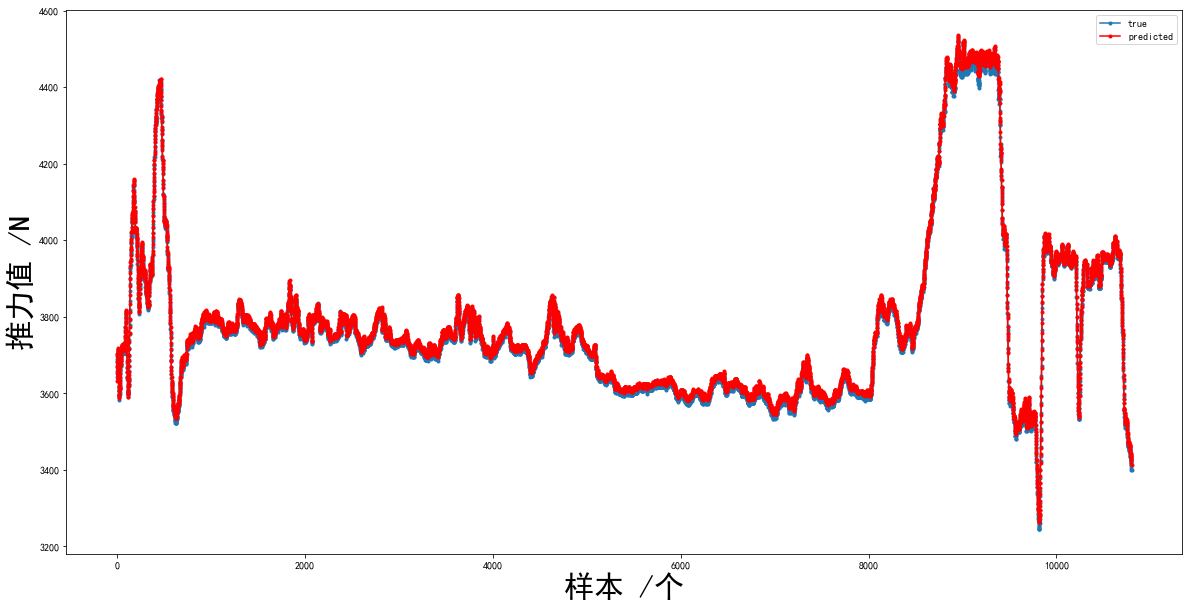

In [48]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();